# Центральная предельная теорема

Центральные предельные теоремы (ЦПТ) — класс теорем в теории вероятностей, утверждающих, 
что сумма достаточно большого количества слабо зависимых случайных величин, имеющих примерно 
одинаковые масштабы (ни одно из слагаемых не доминирует, не вносит в сумму определяющего вклада), 
имеет распределение, близкое к нормальному.

# Пример 

In [1]:
from statistics import multimode

import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import PyPDF2
import re

from collections import Counter
from collections import OrderedDict

%matplotlib inline

Создаем функцию для извлечения информации из PDF файла с непрерывными случайными величинами. Далее будем действовать по методике Extract Load Transform (ETL).

In [2]:
def extract_from_pdf(variant):
    
    reader = PyPDF2.PdfReader('datasets/Непрерывные величны, практикум 1.pdf')
    message = 'Вариант '
    variant = f'Вариант {V}'
    
    for i in range(len(reader.pages)):
    
        text = reader.pages[i].extract_text()
    
        if variant in text:
            
            index = text.index(str(V))
            end = index
            
            while not end == len(text) and not text[end] == 'В':
                message += text[end]
                end += 1
                
            return message

Функция для загрузки параметров из текста, возвращает пару μ и σ_square

In [3]:
def load_parameters(message):
    
    parameters = re.findall(r'\w+', message)
    
    μ = int(parameters[-2])
    σ_square = int(parameters[-1])
    
    return (μ, np.sqrt(σ_square))

Функция для трансформации μ и σ_square в нормальное распределение

In [4]:
def transform_to_distribution(μ, σ_square, size, bin_count):
    
    normal = sps.norm.rvs(size = size, loc = μ, scale = σ_square)

    bins = np.linspace(min(normal), max(normal), num = bin_count)
            
    counter = Counter(np.digitize(normal, bins))
    oredered = OrderedDict(sorted(counter.items(), key = lambda t: t[0]))
        
    data = dict.fromkeys(bins, 0)

    for key, count in oredered.items():
        data[bins[key - 1]] = count
        
    return data

Задаем начальные параметры

In [5]:
V = 15 # номер варианта
N = 1_000 # количество экспериментов
bin_count = 100 # количество интервалов
size = 1_000 # размер каждой выборки

Достаем текст по варианту, загружаем из текста параметры распределения, создаем N распределений и суммируем по кол-ву вхождений 
в интервалы

In [6]:
message = extract_from_pdf(V)
print(message)

μ, σ = load_parameters(message)

summary = {}

for i in range(N):
    
    data = transform_to_distribution(μ, σ, size = size, bin_count = bin_count)
    
    for key in data.keys():
        summary[key] = summary.get(key, 0) + data[key]

oredered = OrderedDict(sorted(summary.items(), key = lambda t: t[0]))

keys = np.array(list(oredered.keys()))
values = np.array(list(oredered.values()))

Вариант 15
X распределен по закону N(2, 6)



Выводим наше суммарное распределение и нормальное с теми же параметрами, не забываем разделить первое на сумму всех значений чтобы свести площадь к единице

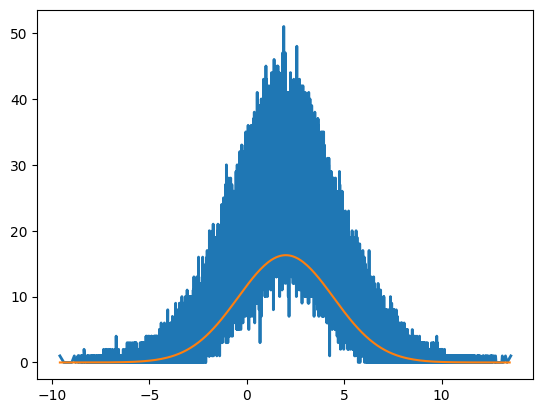

In [7]:
plt.figure()
plt.plot(oredered.keys(), values, lw = 2)

x_axis = np.arange(min(keys), max(keys), 0.1)

norm = sps.norm.pdf(x_axis, μ, σ) * bin_count

plt.plot(x_axis, norm)
plt.show()

Выполним двухвыборочный критерий Колмогорова-Смирнова на соответствие. Нулевая гипотеза состоит в том, что два распределения идентичны.

In [8]:
sps.kstest(norm, values)

KstestResult(statistic=0.34192034482758615, pvalue=1.3018845351403906e-24, statistic_location=0.9873347540323603, statistic_sign=1)

<strong>Вывод:</strong> как мы видим, два распределения очень похожи, и на больших объемах они все ближе и ближе.

<strong>Доделать:</strong>
1. Критерий Колмогорова-Смирнова должен выдавать значение > 0.05
2. График не красивый
3. Вывод слабый